In [3]:
import pandas as pd

# Charger les fichiers CSV des emails
phishing_emails = pd.read_csv("../data/phishing_emails.csv")
legit_emails = pd.read_csv("../data/legitimate_emails.csv")

#
phishing_emails['label'] = 1
legit_emails['label'] = 0

# Combine les deux datasets
all_emails = pd.concat([phishing_emails,legit_emails])

In [4]:
# Afficher un échantillon des données brutes
print(all_emails[['subject', 'body']].head())


                                             subject  \
0             Your MetaMask wallet will be suspended   
1             Your MetaMask wallet will be suspended   
2                        Your shipment is on the way   
3                        Your shipment is on the way   
4  Netflix : We're having some trouble with your ...   

                                                body  
0  Verify your MetaMask Wallet Our system has sho...  
1  Verify your MetaMask Wallet Our system has sho...  
2  Announcing JotForm Tables: When a spreadsheet ...  
3  Announcing JotForm Tables: When a spreadsheet ...  
4  HELLO,   Please note that, your monthly paymen...  


In [5]:
import re


# Fonction pour nettoyer le texte des emails
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    # Retirer les balises HTML
    text = re.sub(r'<.*?>', '', text)
    
    # Remplacer les URLs par un token spécial [URL]
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    
    # Remplacer les caractères non-alphanumériques par des espaces
    text = re.sub(r'\W', ' ', text)
    
    # Remplacer les espaces multiples par un seul espace
    text = re.sub(r'\s+', ' ', text)
    
    # Convertir le texte en minuscules
    return text.lower()

# Nettoyer les colonnes 'subject' et 'body'
all_emails['clean_subject'] = all_emails['subject'].apply(clean_text)
all_emails['clean_body'] = all_emails['body'].apply(clean_text)

# Fusionner le 'subject' et le 'body'
all_emails['clean_text'] = all_emails['clean_subject'] + ' ' + all_emails['clean_body']

# Supprimer les colonnes non utilisées
all_emails_cleaned = all_emails[['clean_text', 'label']]

#

In [6]:
# Vérifier combien de lignes ont un 'clean_body' vide
print(all_emails['clean_body'].isna().sum(), "corps d'emails manquants")

# Vérifier combien de lignes ont un 'clean_subject' vide
print(all_emails['clean_subject'].isna().sum(), "sujets manquants")


0 corps d'emails manquants
0 sujets manquants


In [7]:
# Vérifier le nombre d'emails dans chaque classe après nettoyage
phishing_count = all_emails[all_emails['label'] == 1]['clean_body'].dropna().shape[0]
legit_count = all_emails[all_emails['label'] == 0]['clean_body'].dropna().shape[0]

print(f"Emails de phishing disponibles : {phishing_count}")
print(f"Emails légitimes disponibles : {legit_count}")


Emails de phishing disponibles : 1000
Emails légitimes disponibles : 1000


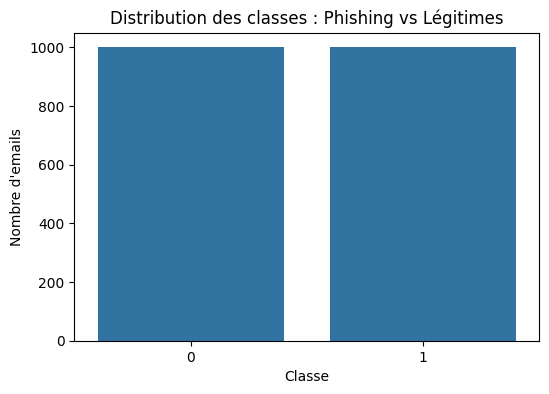

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des labels
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=all_emails)
plt.title('Distribution des classes : Phishing vs Légitimes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'emails')
plt.show()


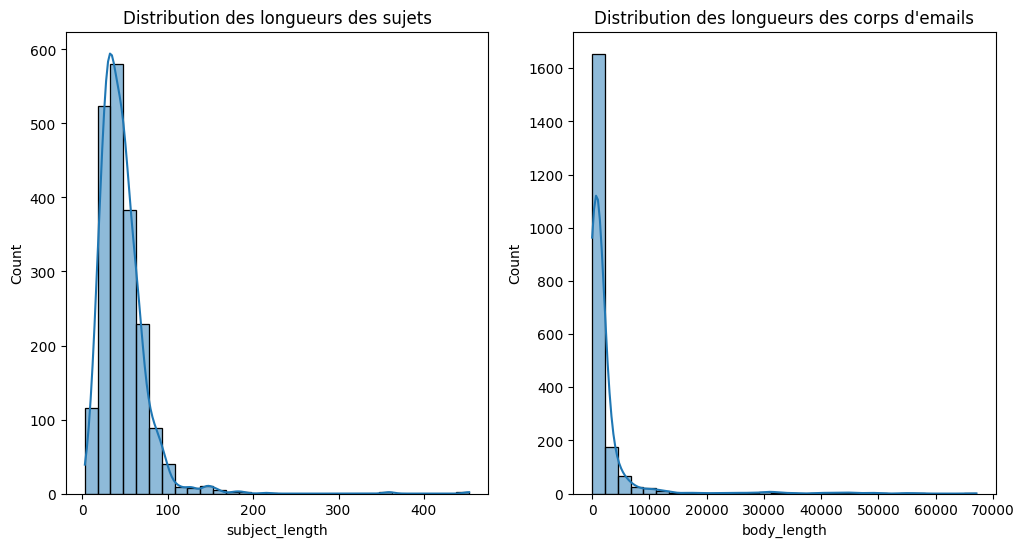

In [9]:
# Calcul de la longueur des sujets et des corps d'emails
all_emails['subject_length'] = all_emails['clean_subject'].apply(lambda x: len(str(x)))
all_emails['body_length'] = all_emails['clean_body'].apply(lambda x: len(str(x)))

# Visualiser la distribution des longueurs
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(all_emails['subject_length'], bins=30, kde=True)
plt.title('Distribution des longueurs des sujets')

plt.subplot(1, 2, 2)
sns.histplot(all_emails['body_length'], bins=30, kde=True)
plt.title('Distribution des longueurs des corps d\'emails')

plt.show()


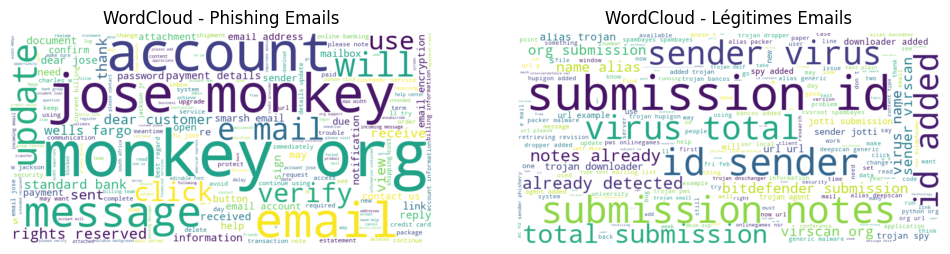

In [10]:
from wordcloud import WordCloud

# WordCloud pour les emails de phishing
phishing_text = ' '.join(all_emails[all_emails['label'] == 1]['clean_body'].dropna())
wordcloud_phishing = WordCloud(width=800, height=400, background_color='white').generate(phishing_text)

# WordCloud pour les emails légitimes
legit_text = ' '.join(all_emails[all_emails['label'] == 0]['clean_body'].dropna())
wordcloud_legit = WordCloud(width=800, height=400, background_color='white').generate(legit_text)

# Afficher les deux WordClouds
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_phishing, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Phishing Emails')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_legit, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Légitimes Emails')

plt.show()


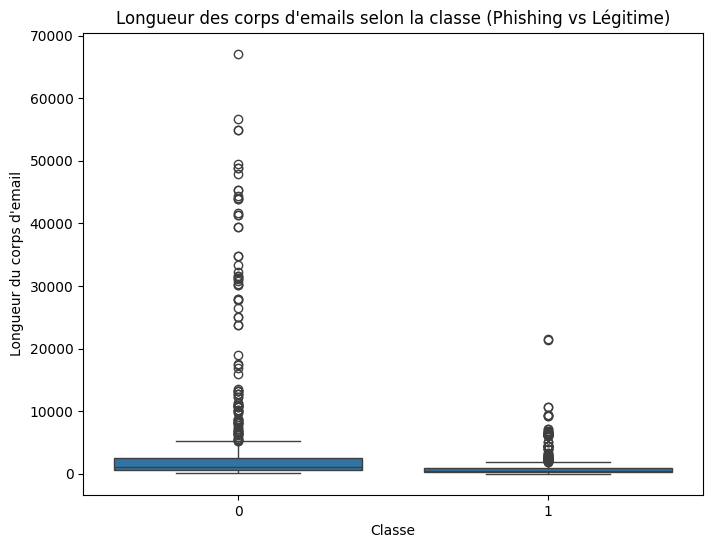

In [11]:
# Relation entre la longueur du corps et l'étiquette phishing
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='body_length', data=all_emails)
plt.title('Longueur des corps d\'emails selon la classe (Phishing vs Légitime)')
plt.xlabel('Classe')
plt.ylabel('Longueur du corps d\'email')
plt.show()


In [12]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [14]:
# Fusionner les colonnes sujet et corps
all_emails['combined_text'] = all_emails['clean_subject'] + " " + all_emails['clean_body']

# Tokenizer les textes
encoded_inputs = tokenizer(
    all_emails['combined_text'].tolist(),  # Convertir la colonne en liste
    add_special_tokens=True,               # Ajouter les tokens spéciaux [CLS] et [SEP]
    max_length=512,                        # Longueur maximale de séquence
    padding='max_length',                  # Compléter les séquences plus courtes
    truncation=True,                       # Tronquer les séquences trop longues
    return_attention_mask=True,            # Retourner le masque d'attention
    return_tensors='pt'                    # Retourner les tenseurs PyTorch
)

# Récupérer les tokens et les masques
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Les labels doivent aussi être convertis en tenseur PyTorch
labels = torch.tensor(all_emails['label'].values)


In [15]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

# Créer des DataLoader PyTorch
train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(train_data, batch_size=16)
test_loader = DataLoader(test_data, batch_size=16)


In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [18]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Utiliser AdamW comme optimiseur
optimizer = AdamW(model.parameters(), lr=2e-5)

# Utiliser CrossEntropyLoss pour la classification binaire
loss_fn = CrossEntropyLoss()

# Si tu as un GPU disponible, n'hésite pas à déplacer le modèle et les données dessus
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU détecté. Utilisation de CUDA pour l'entraînement.")
    print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")
    print(f"Nombre de GPU disponibles : {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("Aucun GPU détecté. Utilisation du CPU pour l'entraînement.")

model.to(device)

print(f"Le modèle a été déplacé sur : {device}")

GPU détecté. Utilisation de CUDA pour l'entraînement.
Nom du GPU : NVIDIA GeForce MX110
Nombre de GPU disponibles : 1
Le modèle a été déplacé sur : cuda


In [20]:
print(f"Device: {device}")
print(f"input_ids device: {input_ids.device}")
print(f"attention_masks device: {attention_masks.device}")
print(f"labels device: {labels.device}")
print(f"model device: {next(model.parameters()).device}")

Device: cuda
input_ids device: cuda:0
attention_masks device: cuda:0
labels device: cuda:0
model device: cuda:0


In [21]:
import time
from tqdm import tqdm

epochs = 4  # Nombre d'époques

# Mesurer le temps total d'exécution
start_time = time.time()

for epoch in range(epochs):
    print(f"Époque {epoch+1}/{epochs}")
    
    # Mettre le modèle en mode entraînement
    model.train()

    total_loss = 0

    # Utiliser tqdm pour afficher une barre de progression
    progress_bar = tqdm(train_loader, desc=f"Époque {epoch+1}", leave=True)
    
    for batch in progress_bar:
        input_ids, attention_masks, labels = [item.to(device) for item in batch]

        # Réinitialiser les gradients
        model.zero_grad()

        # Faire une passe avant
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)

        # Récupérer la perte et les logits
        loss = outputs.loss
        logits = outputs.logits

        # Backpropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        total_loss += loss.item()

        # Mettre à jour la barre de progression
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    print(f"Perte moyenne à la fin de l'époque {epoch+1}: {total_loss/len(train_loader):.4f}")

# Calculer et afficher le temps total d'exécution
end_time = time.time()
total_time = end_time - start_time
print(f"\nTemps total d'exécution: {total_time:.2f} secondes")


Époque 1/4


Époque 1:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
